In [1]:
from scipy.signal import find_peaks
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import scipy.signal
from astropy import units as u
import nana
from scipy.interpolate import CubicSpline
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
from math import cos, sin, radians
from matplotlib.collections import EllipseCollection

In [2]:
def get_started(num_of_peaks, xs, ys): 
    """
    
    Identifies and returns the indices of the highest peaks in a given dataset.
    
    Args:
        num_of_peaks (int): The number of highest peaks to return.
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values

    Returns:
        numpy array: An array of indices corresponding to the highest peaks in `ys`.

    Bugs:
        `num_of_peaks` cannot be greater than the number of detected peaks
        `xs` or `ys` must be NumPy array

    
    """
    indxs, properties = find_peaks(ys)
    return indxs[np.argsort(-ys[indxs])[:num_of_peaks]]

def check_inputs(xs):
    """
    
    Checks whether the input array `xs` is sorted in ascending order.

    Args:
        xs (numpy.ndarray or list): The input array to check.

    Returns:
        bool: `True` if `xs` is sorted in ascending order, otherwise `False`.
    
    """
    for i in range(len(xs)-1):
        if xs[i] > xs[i+1]:
            print("check_inputs(): input xs is badly ordered. Use reorder_inputs to reorder")
            return False
    return True

def reorder_inputs(xs,ys):
    """
    
    Reorders the input arrays `xs` and `ys` in ascending order of `xs`.

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        
    Returns:
        tuple of numpy arrays (sorted xs, sorted ys)

    Bugs:
        `xs` or `ys` must be NumPy array
        `xs` and `ys`must be same length
        
    """
    i = np.argsort(xs)
    return xs[i], ys[i]

#xlist is the teh index left to highest peak, highest peak, and the index right to teh highest peak
def design_matrix(xlist): 
    """
    
    Constructs a design matrix for quadratic curve fitting.

    Args:
        xs (numpy.ndarray): The x-axis values 

    Returns:
        3 x 3 design matrix of numpy arrays

    Bugs:
        xlist must be an numpy array

    Note:
        Note the factor of 0.5 that Hogg likes and no one else
        Also assumes xlist is ordered
    
    """
    return (np.vstack((xlist**0,xlist**1,0.5*xlist**2))).T

def fit_parabola(xs, ys, index):
    """

    Fits a quadratic function to three consecutive data points. Solves for coefficients (b,m,q) in the quadratic
    f(x) = b + m*x + (1/2) * q * x^2

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
        

    Returns:
        tuple: (b, m, q)

    Bugs: 
        index-1` or `index+2` can't be out of bounds
        ``xs` or `ys` must be NumPy array
        
    
    """
    return np.linalg.solve(design_matrix(xs[index-1:index+2]), ys[index-1:index+2])

def refine_peak(xs, ys, index):
    """

    Refines the peak position using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        index (int): The index of peak
    
    Returns:
        3-tuple: (x position of refined peak, y position of refined peak, and second derivative (q))

    Bugs:
        Must be synchronized with the design matrix
        
        
    """
    b,m,q = fit_parabola(xs, ys, index)
    x_peak = -m / q
    return x_peak, 0.5 * q * (x_peak) ** 2 + m * (x_peak) + b, q
    
def refine_peaks(xs, ys, indices):
    """

    Refines the peak position for a set of indices using quadratic fit

    Args:
        xs (numpy.ndarray): The x-axis values 
        ys (numpy.ndarray): The y-axis values
        indices (numpy array): indices of the peaks (this should be the output of get_started()

    Returns:
        three  numpy arrays (array of refined x positions, array of refined y positions, and the second derivatives)
    

    """
    foo = lambda i: refine_peak(xs,ys,i)
    xs_refined, ys_refined, second_derivatives = zip(*list(map(foo,indices)))
    return np.array(xs_refined), np.array(ys_refined), np.array(second_derivatives)


def folding_freq(fs, ps, sampling_time, makeplots=False):
    """
    ##bugs:
    - assumes fs are ordered
    - global delta_f
    """
    fc_guess = 1. / sampling_time
    
    IA = fs < 0.5 * fc_guess
    fsA, psA = fs[IA], ps[IA]
    fsA,psA  = fsA[2:-2],  psA[2:-2]
    cs = CubicSpline(fs, ps, extrapolate=False)
    
    small, tiny = 20 * delta_f, 0.25 * delta_f
    fc_candidates = np.arange(fc_guess - small, fc_guess + small, tiny)
    foos_c = np.array([np.nansum(psA * cs(fc - fsA)) for fc in fc_candidates])
    fc_index = get_started(1,fc_candidates, foos_c)
    fc, _, _ = refine_peaks(fc_candidates, foos_c, fc_index)
    fc = fc[0]
    
    if makeplots:
        plt.plot(fc_candidates, foos_c)
        plt.axvline(fc_guess)
        plt.axvline(fc, color = 'red', alpha = 0.5)
        plt.title(fc)
        plt.show()

    
    return fc


In [3]:
search_result = lk.search_lightcurve('KIC 5202905', mission='Kepler')
lc_collection = search_result.download_all()

In [4]:
lc = lc_collection.stitch()
total_observation_time = (lc.time[-1] - lc.time[0]).value
delta_f = (1/total_observation_time) 
sampling_time= np.median(np.diff(lc.time.value))

In [5]:
f_max = (2 / (sampling_time))
f_min = delta_f/3
frequency_grid_full = np.arange(f_min, f_max, f_min)/(u.day)

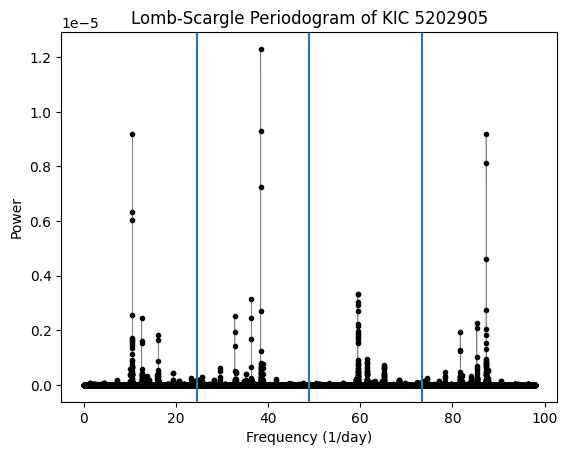

In [6]:
pg_full = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid_full
)

power_full = pg_full.power.value
freq_full = pg_full.frequency.to(1/u.day).value 

plt.plot(freq_full, power_full,'k.')
plt.plot(freq_full, power_full,'k-', lw = 0.5, alpha = 0.5)
plt.xlabel("Frequency (1/day)")
plt.ylabel("Power")
plt.title("Lomb-Scargle Periodogram of KIC 5202905")
plt.axvline(1/sampling_time)
plt.axvline(1/(2*sampling_time))
plt.axvline(3/(2*sampling_time))
plt.show() 

In [7]:
fc = folding_freq(freq_full, power_full, sampling_time, False)

In [8]:
#only the first quarter of the periodogram
frequency_grid = np.arange(f_min, f_max / 4, f_min) / (u.day)

pg = lc.to_periodogram(
    method='lombscargle',
    normalization='psd',
    frequency=frequency_grid
)

power = pg.power.value
freq = pg.frequency.to(1/u.day).value 

In [9]:
t = lc.time.value
flux = lc.flux.value
sigma = lc.flux_err.value

In [10]:
t_clean = np.ma.filled(t, np.nan)
flux_clean = np.ma.filled(flux, np.nan)
sigma_clean = np.ma.filled(sigma, np.nan)

mask = np.isfinite(t_clean) & np.isfinite(flux_clean) & np.isfinite(sigma_clean)

lc = lc[mask]
t_fit = t_clean[mask]
flux_fit = flux_clean[mask]
sigma_fit = sigma_clean[mask]

In [16]:
lc_exptime = (6.52 * 270) / (60 * 60 * 24) #days, see Kepler Data Processing Handbook, Section 3.1
weight_fit = 1 / sigma_fit**2

def integral_design_matrix(ts, om, T):
    """
    ##bugs:
    - assumes all data points have the same exposure time, `T`
    - not numerically stable when `om * T` is small
    """
    return np.vstack([
        np.ones_like(ts),
        (+ np.sin(om * (ts + T/2)) - np.sin(om * (ts - T/2))) / (om * T),
        (- np.cos(om * (ts + T/2)) + np.cos(om * (ts - T/2))) / (om * T)
    ]).T

def weighted_least_squares(A, b, weights):
    ATA = A.T @ (A * weights[:, np.newaxis])
    ATb = A.T @ (b * weights)
    return A @ np.linalg.solve(ATA, ATb)

def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

In [17]:
def integral_chi_squared(om, ts, ys, ws, T):
    A = integral_design_matrix(ts, om, T)
    return np.sum(ws * (ys - weighted_least_squares(A, ys, ws))**2)

In [18]:
def find_min_and_refine(xs,ys):
    indxs, properties = find_peaks(-ys)
    min_index =  indxs[np.argsort(ys[indxs])[:1]]
    refined_x, refined_y, second_derivative = refine_peaks(xs, ys, min_index)
    return refined_x, refined_y

In [19]:
indices = get_started(1, freq, power)
fas, _ , _ = refine_peaks(freq, power, indices)
A = fas
B = fc - fas
C = fc + fas

[1306459.375]


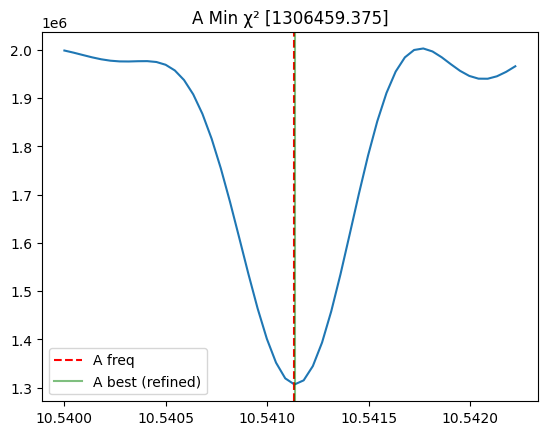

In [20]:
#chi-squared for A

fine_freqsA = np.arange(A[0] - 5 * f_min, A[0] + 5 * f_min, 0.2 * f_min)  
chi2_fineA = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsA])
best_freqA, best_chi2A = find_min_and_refine(fine_freqsA,chi2_fineA)

plt.plot(fine_freqsA, chi2_fineA)
plt.title(f"A Min χ² {best_chi2A}")
plt.axvline(A, color='red', linestyle='--', label = 'A freq')
plt.axvline(best_freqA, color='green', alpha = 0.5, label = 'A best (refined)')
plt.legend()
print(best_chi2A)

In [ ]:
#chi-squared for B

fine_freqsB = np.arange(B[0]- 5 * f_min, B[0] + 5 * f_min, 0.2 * f_min)  
chi2_fineB = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsB])
best_freqB, best_chi2B = find_min_and_refine(fine_freqsB,chi2_fineB)

plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.plot(fine_freqsB, chi2_fineB)
plt.title(f"B Min χ² {best_chi2B}")
plt.axvline(B, color='red', linestyle='--', label = 'B freq')
plt.axvline(best_freqB, color='green', alpha = 0.5, label = 'B best (refined)')
plt.legend()
plt.show()


In [ ]:
#chi-squared for C

fine_freqsC = np.arange(C[0] - 5 * f_min, C[0] + 5 * f_min, 0.2 * f_min)  
chi2_fineC = np.array([integral_chi_squared(2. * np.pi * f, t_fit, flux_fit, weight_fit, lc_exptime) for f in fine_freqsC])
best_freqC, best_chi2C = find_min_and_refine(fine_freqsC,chi2_fineC)

plt.plot(fine_freqsC, chi2_fineC)
plt.title(f"C Min χ² {best_chi2C}")
plt.axvline(C, color='red', linestyle='--', label = 'C freq')
plt.axvline(best_freqC, color='green', alpha = 0.5, label = 'C best (refined)')
plt.legend()

In [ ]:
##just define fas to be the refined peaks of the quarter periodogram
#then do the operations with fc to find As, Bs, and Cs
#then do the chisquared minimum shit for the three corresponding frequencies
#out of the three frequencies, lowest chi-squared --> true peak
#then take this peak and tets coherence


In [ ]:
nu = best_freqB

In [ ]:
def check_coherence(ts, ys, weights, om):
    """
    assumes a lot of things about the data
    """
    axes, As,Bs, traces, dets = [],[], [], [], []
    cases = [(np.ones_like(ts).astype(bool), "all"),
             (ts < np.median(ts), "early"),
             (ts > np.median(ts), "late")]
    for I, name in cases:
        A = integral_design_matrix(ts[I], om, lc_exptime)
        pars, invar, trace, det = weighted_least_squares(A, ys[I], weights[I])
        a,b = pars[1], pars[2]
        As.append(a)
        Bs.append(b)
        traces.append(trace)
        dets.append(det)
        covariance = np.linalg.inv(invar)
        covariance2 = covariance[1:, 1:]
        eigvals, eigvecs = np.linalg.eigh(covariance2)
        axis1 = np.sqrt(eigvals)*eigvecs[:, 0] 
        axis2 = np.sqrt(eigvals)*eigvecs[:, 1] 
        axes.append((axis1, axis2))
    return axes[0], axes[1], axes[2], As, Bs, traces, dets

In [ ]:
all, early, late, As, Bs, traces, dets = check_coherence(t_fit, flux_fit, weight_fit, 2. * np.pi * nu)